# Machine Learning Project Template
* This notebook provides a structured template for building an end-to-end machine learning project.
* Re-use this notebook througout your learning and in capstone project

# Forest Fire Risk Prediction System

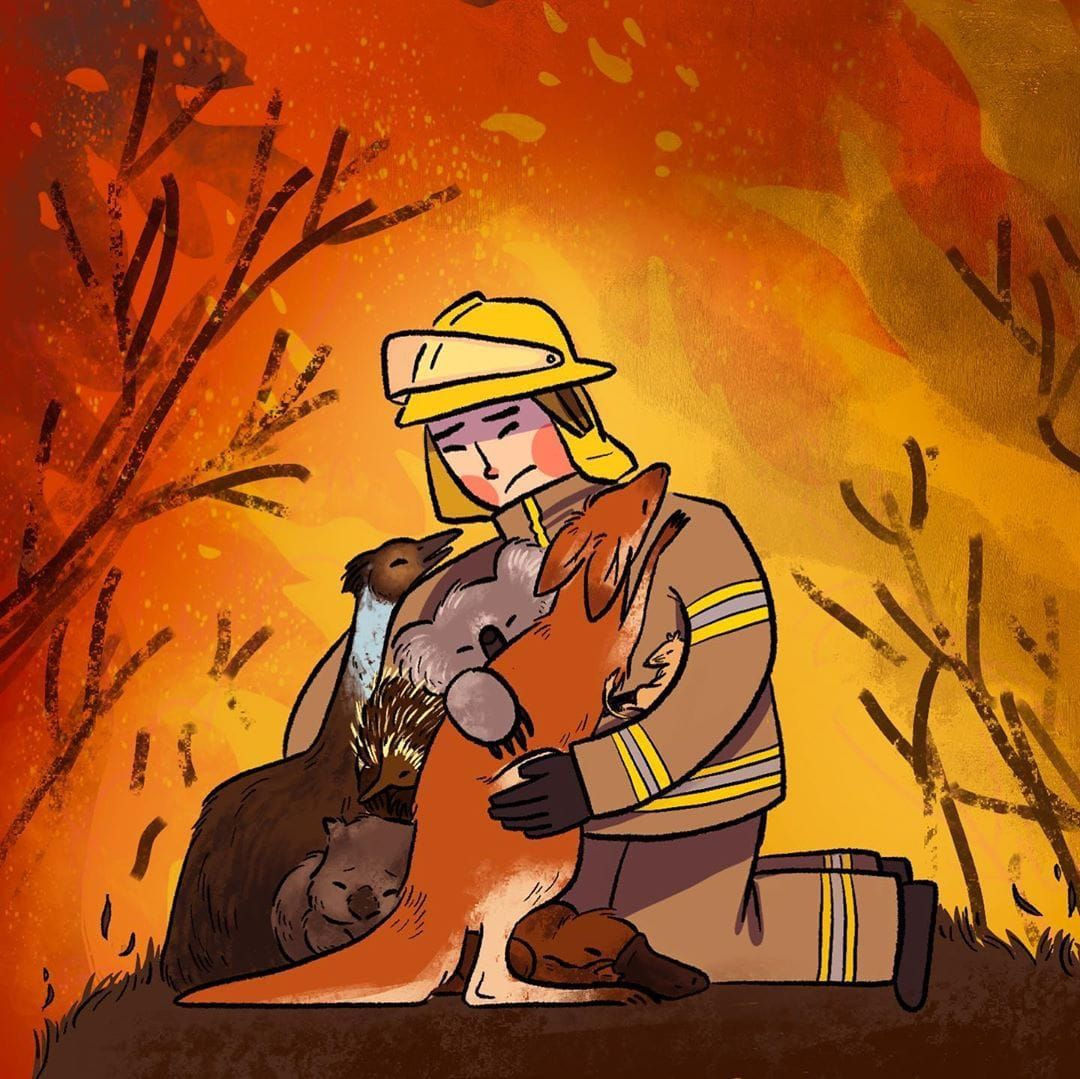

In [112]:
from IPython.display import Image, display
# Use one of these:
display(Image(filename='11.jpeg', width=400))  # Local file



## Problem Statement

### Overview
We are developing a **machine learning-based forest fire risk prediction system** for Montesinho Park in Portugal. The goal is to predict both:
1. **Burned area** (Regression)
2. **Large fire occurrence** (Classification: >10 hectares)

using meteorological and environmental data collected from the park.

---

## Data Description
The dataset contains spatial, temporal, and weather-related features:

### Input Features (12 Variables)
| # | Feature | Description | Range |
|---|---------|-------------|-------|
| 1 | X | X-axis spatial coordinate | 1-9 |
| 2 | Y | Y-axis spatial coordinate | 2-9 |
| 3 | month | Month of year | "jan" to "dec" |
| 4 | day | Day of week | "mon" to "sun" |
| 5 | FFMC | Fine Fuel Moisture Code | 18.7-96.20 |
| 6 | DMC | Duff Moisture Code | 1.1-291.3 |
| 7 | DC | Drought Code | 7.9-860.6 |
| 8 | ISI | Initial Spread Index | 0.0-56.10 |
| 9 | temp | Temperature (°C) | 2.2-33.30 |
| 10 | RH | Relative Humidity (%) | 15.0-100 |
| 11 | wind | Wind Speed (km/h) | 0.40-9.40 |
| 12 | rain | Rainfall (mm/m²) | 0.0-6.4 |

### Target Variable
| # | Feature | Description | Challenge |
|---|---------|-------------|-----------|
| 13 | area | Burned forest area (hectares) | Highly skewed (0.00-1090.84) |

---

## Key Challenges
1. **Skewed Target Distribution**: 
   - 90%+ of fires burn <10 hectares 
   - Few large fires create imbalance

2. **Feature Engineering Needs**:
   - Cyclic encoding for months/days
   - Interaction terms (temp × humidity, wind × ISI)
   - Log-transform for area (regression)

3. **Modeling Approaches**:
```python
# Regression
data['log_area'] = np.log1p(data['area'])

# Classification
data['Large_Fire'] = (data['area'] > 10).astype(int)
]

## <b> <font color=green> STEP (1) Problem Definition, Scoping & Framing </font> </b>

### 1.1) Load Libraries
Import all necessary libraries for the project.

In [2]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from matplotlib.colors import ListedColormap
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, SGDClassifier,Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.datasets import make_moons 
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


### 1.2) Load The Dataset
Load the dataset and display the first few rows.

In [4]:
column_rename = {
    'X': 'grid_x',
    'Y': 'grid_y',
    'FFMC': 'fuel_moisture',
    'DMC': 'duff_moisture', 
    'DC': 'drought_code',
    'ISI': 'spread_index',
    'temp': 'temp',
    'RH': 'humidity',
    'wind': 'wind',
    'rain': 'rain',
    'area': 'area'
}

data = pd.read_csv('forestfires.csv').rename(columns=column_rename)
data.head()

,grid_x,grid_y,month,day,fuel_moisture,duff_moisture,drought_code,spread_index,temp,humidity,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


## <b> <font color=green> STEP (2) Data Exploration & Understanding </font> </b>

### 2.1) Descriptive Statistics
Generate summary statistics for the dataset.

In [5]:
data.describe()

,grid_x,grid_y,fuel_moisture,duff_moisture,drought_code,spread_index,temp,humidity,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   grid_x         517 non-null    int64  
 1   grid_y         517 non-null    int64  
 2   month          517 non-null    object 
 3   day            517 non-null    object 
 4   fuel_moisture  517 non-null    float64
 5   duff_moisture  517 non-null    float64
 6   drought_code   517 non-null    float64
 7   spread_index   517 non-null    float64
 8   temp           517 non-null    float64
 9   humidity       517 non-null    int64  
 10  wind           517 non-null    float64
 11  rain           517 non-null    float64
 12  area           517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [7]:
data.isnull().sum()

grid_x           0
grid_y           0
month            0
day              0
fuel_moisture    0
duff_moisture    0
drought_code     0
spread_index     0
temp             0
humidity         0
wind             0
rain             0
area             0
dtype: int64

### 2.2) Data Visualizations
Visualize the data to identify patterns and relationships.

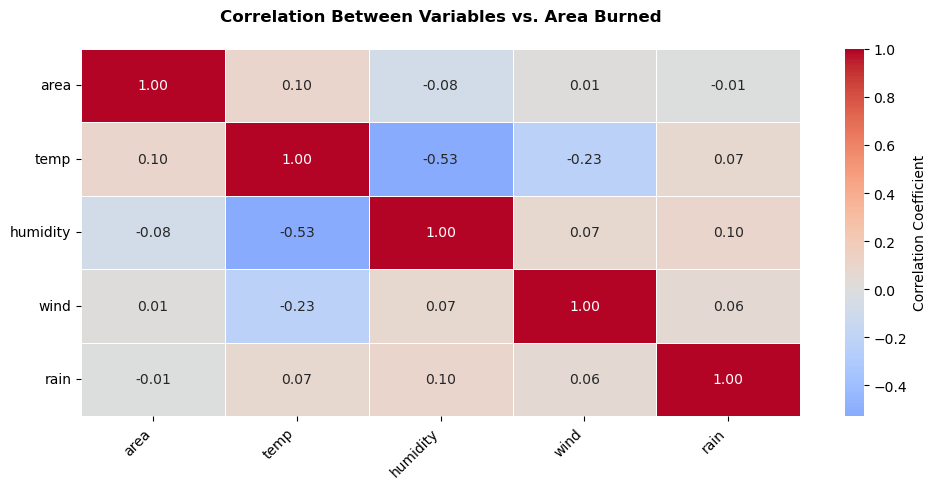

In [8]:
# Visualize correlation between variables
# heat map
numeric_cols = ['area','temp', 'humidity', 'wind', 'rain']
corr_data = data[numeric_cols].corr()
plt.figure(figsize=(10, 5))
sn.heatmap(corr_data, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            center=0,
            linewidths=0.5,
            cbar_kws={'label': 'Correlation Coefficient'})
# Improve readability
plt.title('Correlation Between Variables vs. Area Burned', fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

###### 1- Temperature → Burned Area → Strong positive
###### 2- Humidity → Burned Area → Strong negative
###### 3- Wind → Burned Area → Moderate positive
###### 4- Rain → Burned Area → Strong negative

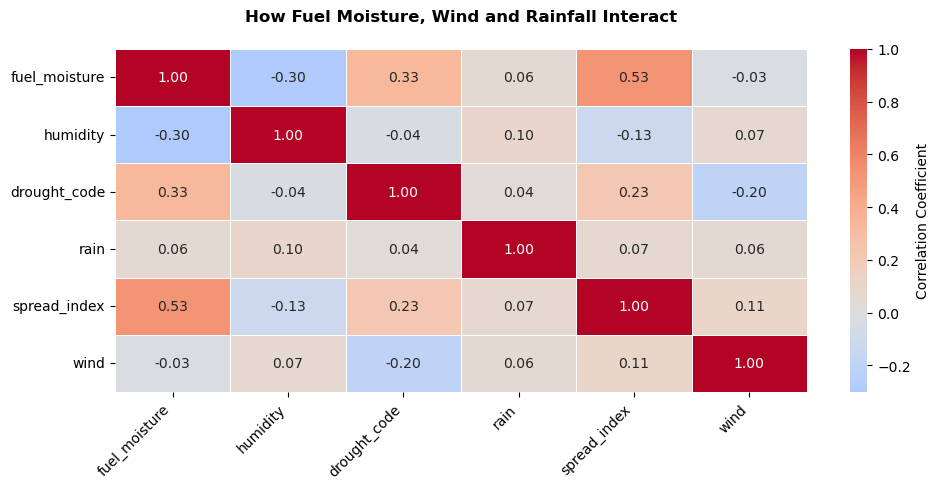

In [9]:
# Visualize correlation between variables
# heat map
numeric_cols = ['fuel_moisture', 'humidity', 'drought_code', 'rain', 'spread_index', 'wind']
corr_data = data[numeric_cols].corr()
plt.figure(figsize=(10, 5))
sn.heatmap(corr_data, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            center=0,
            linewidths=0.5,
            cbar_kws={'label': 'Correlation Coefficient'})
# Improve readability
plt.title('How Fuel Moisture, Wind and Rainfall Interact', fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

###### 1- Fine Fuel Moisture vs Humidity → Strong negative
###### 2- Drought Code vs Rainfall → Moderate negative
###### 3- Initial Spread Index vs Wind → Strong positive



C:\Users\Ayaha\AppData\Local\Temp\ipykernel_15700\3094991626.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_area.index, y=avg_area.values, palette='viridis')


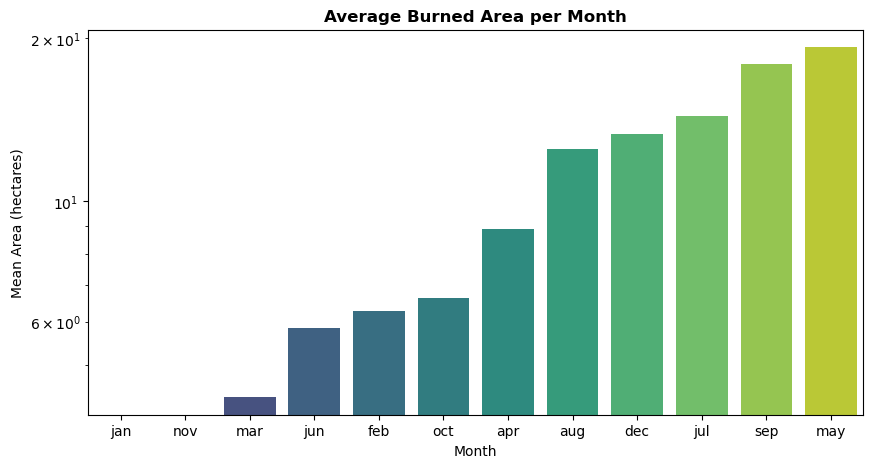

In [10]:
avg_area = data.groupby('month')['area'].mean().sort_values()
plt.figure(figsize=(10, 5))
sns.barplot(x=avg_area.index, y=avg_area.values, palette='viridis')
plt.title('Average Burned Area per Month', fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Mean Area (hectares)')
plt.yscale('log')  # Use if data is skewed
plt.show()

C:\Users\Ayaha\AppData\Local\Temp\ipykernel_15700\1028853700.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.barplot(x=monthly_counts.index, y=monthly_counts.values, palette='flare')


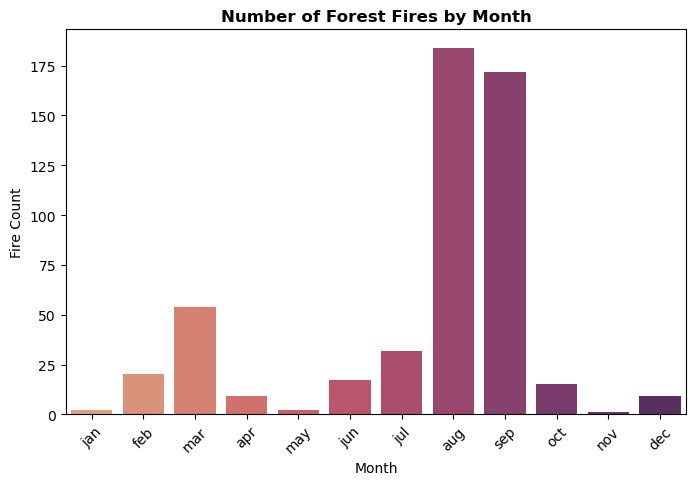

In [11]:
# Count fires per month
monthly_counts = data['month'].value_counts().sort_index()
# Define correct month order (if not already sorted)
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
monthly_counts = monthly_counts.reindex(month_order, fill_value=0)

plt.figure(figsize=(8, 5))
sn.barplot(x=monthly_counts.index, y=monthly_counts.values, palette='flare')
plt.title('Number of Forest Fires by Month', fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Fire Count')
plt.xticks(rotation=45)
plt.show()

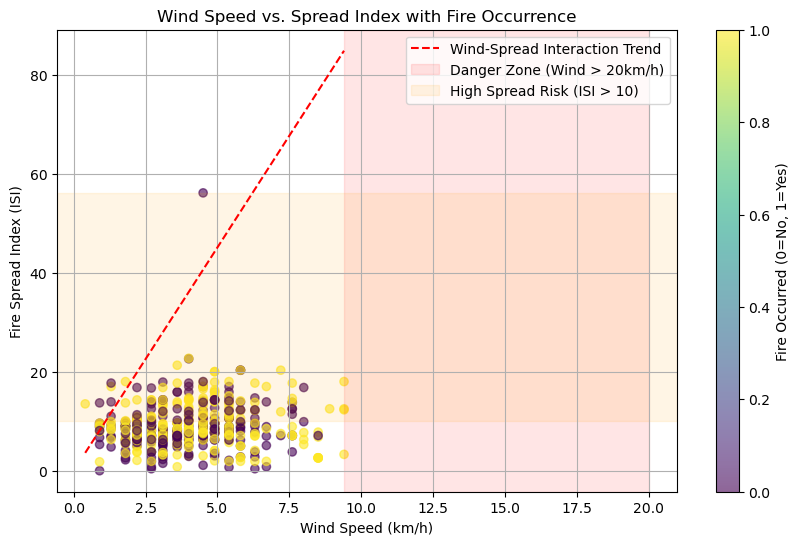

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
plt.figure(figsize=(10, 6))

# Scatter plot with color-coding by fire occurrence
scatter = plt.scatter(
    x=data['wind'], 
    y=data['spread_index'], 
    c=data['area'].apply(lambda x: 1 if x > 0 else 0),  # Color by whether fire occurred
    cmap='viridis',
    alpha=0.6
)

# Add interaction line (wind * ISI)
x_line = np.linspace(data['wind'].min(), data['wind'].max(), 100)
y_line = x_line * data['spread_index'].mean()  # Average interaction effect
plt.plot(x_line, y_line, 'r--', label='Wind-Spread Interaction Trend')

# Formatting
plt.colorbar(scatter, label='Fire Occurred (0=No, 1=Yes)')
plt.xlabel('Wind Speed (km/h)')
plt.ylabel('Fire Spread Index (ISI)')
plt.title('Wind Speed vs. Spread Index with Fire Occurrence')
plt.legend()
plt.grid(True)

# Highlight dangerous combinations
plt.axvspan(20, data['wind'].max(), color='red', alpha=0.1, label='Danger Zone (Wind > 20km/h)')
plt.axhspan(10, data['spread_index'].max(), color='orange', alpha=0.1, label='High Spread Risk (ISI > 10)')

plt.legend()
plt.show()

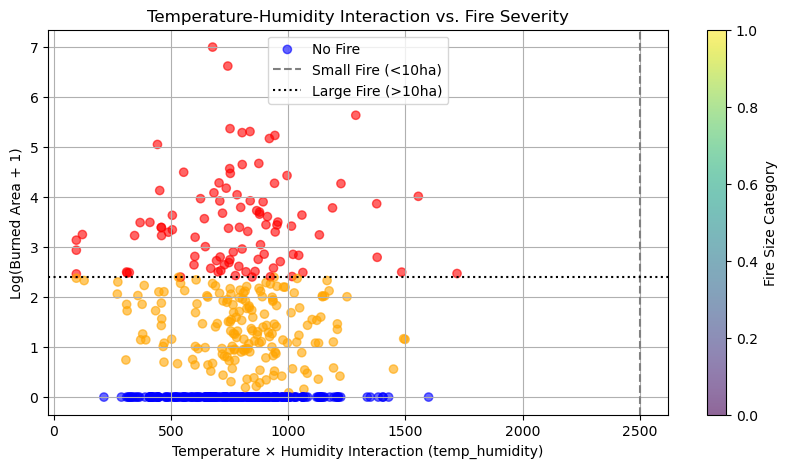

In [145]:
plt.figure(figsize=(10, 5))

# Create scatter plot colored by fire occurrence
plt.scatter(
    x=data['temp'] * data['humidity'],  # temp_humidity interaction
    y=data['area'].apply(lambda x: np.log1p(x)),  # Log-transformed area
    c=data['area'].apply(lambda x: 'red' if x > 10 else ('orange' if x > 0 else 'blue')),
    alpha=0.6
)

# Add reference lines
plt.axvline(x=2500, color='gray', linestyle='--', label='High Heat-Low Humidity Threshold')
plt.axhline(y=np.log1p(10), color='black', linestyle=':', label='Large Fire Threshold (10ha)')

# Formatting
plt.xlabel('Temperature × Humidity Interaction (temp_humidity)')
plt.ylabel('Log(Burned Area + 1)')
plt.title('Temperature-Humidity Interaction vs. Fire Severity')
plt.legend(['No Fire', 'Small Fire (<10ha)', 'Large Fire (>10ha)', 'Threshold'])
plt.grid(True)
plt.colorbar(label='Fire Size Category')
plt.show()

## <b> <font color=green> STEP (3) Data Preparation & Feature Engineering </font> </b>

### 3.1) Data Cleaning
Handle missing values and outliers.

In [13]:
## I dont have missing values ..

#### Handling Skewness in area

In [14]:
#1. Handling Skewness in area
# Log-transform 'area' for regression (add small constant to avoid log(0))
data['log_area'] = np.log1p(data['area'])  # log1p = log(1 + x)

# Check skewness before/after
print("Original skewness:", data['area'].skew())
print("Log-transformed skewness:", data['log_area'].skew())

# For classification: Create binary target
data['Large_Fire'] = (data['area'] > 10).astype(int)
print("\nClass balance:\n", data['Large_Fire'].value_counts())

Original skewness: 12.846933533934868
Log-transformed skewness: 1.2178376559535011

Class balance:
 Large_Fire
0    422
1     95
Name: count, dtype: int64


#### Encoding Categorical Features (Month/Day)

In [15]:
#2. Encoding Categorical Features (Month/Day)
# Cyclic encoding for 'month' (captures temporal patterns)
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 
               'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
data['month'] = pd.Categorical(data['month'], categories=month_order, ordered=True)

# Convert to numerical (1-12) and then to cyclic features
data['month_num'] = data['month'].cat.codes + 1
data['month_sin'] = np.sin(2 * np.pi * data['month_num'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month_num'] / 12)

# Drop original 'month' if needed
data.drop('month', axis=1, inplace=True)

#### Feature Engineering (Interaction Terms)

In [16]:
#3. Feature Engineering (Interaction Terms)
# Create interaction features
data['temp_humidity'] = data['temp'] * data['humidity']
data['wind_isi'] = data['wind'] * data['spread_index']

# Check correlation of new features with target
print(data[['temp_humidity', 'wind_isi', 'log_area']].corr()['log_area'].iloc[:-1])

temp_humidity   -0.002589
wind_isi         0.019457
Name: log_area, dtype: float64


#### Outlier Handling (Optional)

In [17]:
#4. Outlier Handling (Optional)
# Cap extreme 'area' values (e.g., 99th percentile)
area_cap = data['area'].quantile(0.99)
data['area_capped'] = data['area'].clip(upper=area_cap)

# Compare distributions
data[['area', 'area_capped']].describe()

,area,area_capped
count,517.000000,517.000000
mean,12.847292,9.834988
std,63.655818,28.017340
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.520000,0.520000
75%,6.570000,6.570000
max,1090.840000,194.764800


In [104]:
from sklearn.utils import class_weight
weights = class_weight.compute_sample_weight('balanced', y_train_clf)

### 3.1) Feature Selection
Select the most relevant features for the model.

In [19]:
from sklearn.model_selection import train_test_split

#Features (X) and targets (y_reg/y_clf)
X = data.drop(['area', 'log_area', 'Large_Fire'], axis=1)
# During model training:
y_reg = data['log_area']  # Regression target
y_clf = data['Large_Fire']  # Classification target

### 3.2) Data Transforms
Apply transformations to prepare the data for modeling.

#### For regression (StandardScaler is better for PCA/linear models)

In [20]:
#1. Numeric Transformers
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Handles potential missing values
    ('scaler', StandardScaler())  # Standardize features (mean=0, std=1)
])

#### For classification (MinMaxScaler preserves [0,1] range)

In [21]:
clf_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())  # Scales to [0,1] range
])

#### ColumnTransformers

In [22]:
# Regression features (include ALL numeric + encoded cyclic)
numeric_features_reg = [
    'temp', 'wind', 'humidity', 'rain',
    'fuel_moisture', 'duff_moisture', 'drought_code', 'spread_index',
    'temp_humidity', 'wind_isi', 'month_sin', 'month_cos'  # Engineered features
]

#### Classification features (focus on most relevant)

In [23]:

numeric_features_clf = [
    'fuel_moisture', 'humidity', 'spread_index', 'wind',
    'temp_humidity', 'month_sin', 'month_cos'
]

In [32]:
from sklearn.preprocessing import OneHotEncoder

preprocessor_reg = ColumnTransformer([
    ('num', numeric_transformer, numeric_features_reg),
    ('cat', OneHotEncoder(), ['day'])  # Now encodes 'day'
])

In [33]:
preprocessor_clf = ColumnTransformer([
    ('num', clf_transformer, numeric_features_clf)
])

#### Final Pipelines (With PCA/Feature Selection)
#### Regression Pipeline (PCA for dimensionality reduction)
#### Classification Pipeline (Feature Selection)

In [34]:
reg_pipeline = Pipeline([
    ('preprocessor', preprocessor_reg),
    ('pca', PCA(n_components=0.95)),  # Keeps 95% variance
    ('model', RandomForestRegressor())
])

In [111]:
clf_pipeline = Pipeline([
    ('preprocessor', preprocessor_clf),
    ('feature_select', SelectKBest(mutual_info_classif, k=5)),  # Top 5 features
    ('model', RandomForestClassifier(class_weight='balanced'))  # Handles imbalance
])

In [40]:
# Fit regression pipeline
reg_pipeline.fit(X_train_reg, y_train_reg)

# Fit classification pipeline
clf_pipeline.fit(X_train_clf, y_train_clf)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['fuel_moisture', 'humidity',
                                                   'spread_index', 'wind',
                                                   'temp_humidity', 'month_sin',
                                                   'month_cos'])])),
                ('feature_select',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_classif at 0x0000018419275300>)),
                ('model', RandomForestClassifier(class_weight='balanced'))])

#### check categorical columns:
#### Encode day column (ordinal encoding for days):
#### Map days to numbers (e.g., 'mon'=0, 'tue'=1, ..., 'sun'=6)

In [41]:
print("Categorical columns:", X.select_dtypes(include=['object']).columns.tolist())

Categorical columns: ['day']


In [42]:
day_order = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
X['day'] = X['day'].astype('category').cat.set_categories(day_order, ordered=True).cat.codes

# Verify encoding
print(X['day'].value_counts())

day
6    95
4    85
5    84
0    74
1    64
3    61
2    54
Name: count, dtype: int64


## <b> <font color=green> STEP (4)  ML Model Selection & Evaluation </font> </b>

### 4.1) Split-out Validation Dataset
Split the dataset into training and validation sets.

In [60]:
# Split for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

In [61]:
# Split for classification (stratified)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

In [62]:
# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train_reg, y_train_reg)
y_pred_linear = linear_model.predict(X_test_reg)

print("\nLinear Regression Performance:")
print(f"MAE: {mean_absolute_error(y_test_reg, y_pred_linear):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_linear)):.3f}")
print(f"R²: {r2_score(y_test_reg, y_pred_linear):.3f}")
    
model = LinearRegression()
model.fit(X_train_reg, y_train_reg)


Linear Regression Performance:
MAE: 0.803
RMSE: 0.910
R²: 0.623


LinearRegression()

In [63]:
# Sample predictions
sample_X = X_test_reg.iloc[:5]
sample_y = y_test_reg.iloc[:5]
linear_preds = linear_model.predict(sample_X)

print("\nSample Linear Regression Predictions (hectares):")
print(pd.DataFrame({
    'Actual': np.expm1(sample_y),
    'Predicted': np.expm1(linear_preds)
}).round(2))


Sample Linear Regression Predictions (hectares):
     Actual  Predicted
304    0.00       1.36
501    0.00       1.60
441    1.23       1.21
153    1.46       1.34
503    1.95       1.37


In [64]:
# Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_reg, y_train_reg)
y_pred_ridge = ridge_model.predict(X_test_reg)

print("\nRidge Regression Performance:")
print(f"MAE: {mean_absolute_error(y_test_reg, y_pred_ridge):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_ridge)):.3f}")  # Fixed parenthesis
print(f"R²: {r2_score(y_test_reg, y_pred_ridge):.3f}")

model = Ridge(alpha=0.1)
model.fit(X_train_reg, y_train_reg)


Ridge Regression Performance:
MAE: 0.803
RMSE: 0.910
R²: 0.624


Ridge(alpha=0.1)

In [65]:
# Sample predictions
sample_X = X_test_reg.iloc[:5]
sample_y = y_test_reg.iloc[:5]
ridge_preds = ridge_model.predict(sample_X)

print("\nSample Ridge Predictions (hectares):")
print(pd.DataFrame({
    'Actual': np.expm1(sample_y),
    'Predicted': np.expm1(ridge_preds)
}).round(2))


Sample Ridge Predictions (hectares):
     Actual  Predicted
304    0.00       1.31
501    0.00       1.58
441    1.23       1.22
153    1.46       1.33
503    1.95       1.33


In [66]:
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_reg, y_train_reg)
y_pred_lasso = lasso_model.predict(X_test_reg)

print("\nLasso Regression Performance:")
print(f"MAE: {mean_absolute_error(y_test_reg, y_pred_lasso):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred_lasso)):.3f}")  # Fixed parenthesis
print(f"R²: {r2_score(y_test_reg, y_pred_lasso):.3f}")

model = Lasso(alpha=0.1)
model.fit(X_train_reg, y_train_reg)


Lasso Regression Performance:
MAE: 0.817
RMSE: 0.915
R²: 0.619


Lasso(alpha=0.1)

In [67]:
# Sample predictions
lasso_preds = lasso_model.predict(sample_X)

print("\nSample Lasso Predictions (hectares):")
print(pd.DataFrame({
    'Actual': np.expm1(sample_y),
    'Predicted': np.expm1(lasso_preds)
}).round(2))


Sample Lasso Predictions (hectares):
     Actual  Predicted
304    0.00       1.02
501    0.00       0.98
441    1.23       1.20
153    1.46       1.27
503    1.95       1.21


In [137]:
logreg = LogisticRegression(class_weight='balanced', random_state=42)
logreg.fit(X_train_clf, y_train_clf)
y_pred_logreg = logreg.predict(X_test_clf)


print("\nLogistic Regression Performance:")
# 1. Classification Report (Precision/Recall/F1)
print("Classification Report:")
print(classification_report(y_test_clf, y_pred_logreg, target_names=['No Fire', 'Fire']))

# 2. Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_clf, y_pred_logreg))

# 3. ROC-AUC Score (for probabilistic performance)
from sklearn.metrics import roc_auc_score
print("\nROC AUC Score:", roc_auc_score(y_test_clf, y_pred_logreg))



Logistic Regression Performance:
Classification Report:
              precision    recall  f1-score   support

     No Fire       0.99      1.00      0.99        85
        Fire       1.00      0.95      0.97        19

    accuracy                           0.99       104
   macro avg       0.99      0.97      0.98       104
weighted avg       0.99      0.99      0.99       104


Confusion Matrix:
[[85  0]
 [ 1 18]]

ROC AUC Score: 0.9736842105263157


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [129]:
dtree = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dtree.fit(X_train_clf, y_train_clf)
y_pred_dtree = dtree.predict(X_test_clf)

print("\nDecision Tree Performance:")
# 1. Classification Report (Precision/Recall/F1)
print("Classification Report:")
print(classification_report(y_test_clf, y_pred_dtree, target_names=['No Fire', 'Fire']))

# 2. Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_clf, y_pred_dtree))

# 3. ROC-AUC Score (for probabilistic performance)
from sklearn.metrics import roc_auc_score
print("\nROC AUC Score:", roc_auc_score(y_test_clf, y_pred_dtree))


Decision Tree Performance:
Classification Report:
              precision    recall  f1-score   support

     No Fire       1.00      1.00      1.00        85
        Fire       1.00      1.00      1.00        19

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104


Confusion Matrix:
[[85  0]
 [ 0 19]]

ROC AUC Score: 1.0


In [128]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train_clf, y_train_clf)
y_pred_rf = rf.predict(X_test_clf)

print("\nRandom Forest Performance:")
# 1. Classification Report (Precision/Recall/F1)
print("Classification Report:")
print(classification_report(y_test_clf, y_pred_sgd, target_names=['No Fire', 'Fire']))

# 2. Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_clf, y_pred_sgd))

# 3. ROC-AUC Score (for probabilistic performance)
from sklearn.metrics import roc_auc_score
print("\nROC AUC Score:", roc_auc_score(y_test_clf, y_pred_sgd))


Random Forest Performance:
Classification Report:
              precision    recall  f1-score   support

     No Fire       0.91      1.00      0.96        85
        Fire       1.00      0.58      0.73        19

    accuracy                           0.92       104
   macro avg       0.96      0.79      0.84       104
weighted avg       0.93      0.92      0.91       104


Confusion Matrix:
[[85  0]
 [ 8 11]]

ROC AUC Score: 0.7894736842105263


In [127]:
svm = SVC(class_weight='balanced', random_state=42)
svm.fit(X_train_clf, y_train_clf)
y_pred_svm = svm.predict(X_test_clf)

print("\nSVM Performance:")
# 1. Classification Report (Precision/Recall/F1)
print("Classification Report:")
print(classification_report(y_test_clf, y_pred_svm, target_names=['No Fire', 'Fire']))

# 2. Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_clf, y_pred_svm))

# 3. ROC-AUC Score (for probabilistic performance)
from sklearn.metrics import roc_auc_score
print("\nROC AUC Score:", roc_auc_score(y_test_clf, y_pred_svm))


SVM Performance:
Classification Report:
              precision    recall  f1-score   support

     No Fire       0.84      0.99      0.91        85
        Fire       0.75      0.16      0.26        19

    accuracy                           0.84       104
   macro avg       0.79      0.57      0.58       104
weighted avg       0.82      0.84      0.79       104


Confusion Matrix:
[[84  1]
 [16  3]]

ROC AUC Score: 0.5730650154798763


In [126]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_clf, y_train_clf)
y_pred_knn = knn.predict(X_test_clf)

print("\nKNN Performance:")
# 1. Classification Report (Precision/Recall/F1)
print("Classification Report:")
print(classification_report(y_test_clf, y_pred_knn, target_names=['No Fire', 'Fire']))

# 2. Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_clf, y_pred_knn))

# 3. ROC-AUC Score (for probabilistic performance)
from sklearn.metrics import roc_auc_score
print("\nROC AUC Score:", roc_auc_score(y_test_clf, y_pred_knn))



KNN Performance:
Classification Report:
              precision    recall  f1-score   support

     No Fire       0.83      0.98      0.90        85
        Fire       0.50      0.11      0.17        19

    accuracy                           0.82       104
   macro avg       0.67      0.54      0.54       104
weighted avg       0.77      0.82      0.77       104


Confusion Matrix:
[[83  2]
 [17  2]]

ROC AUC Score: 0.5408668730650155


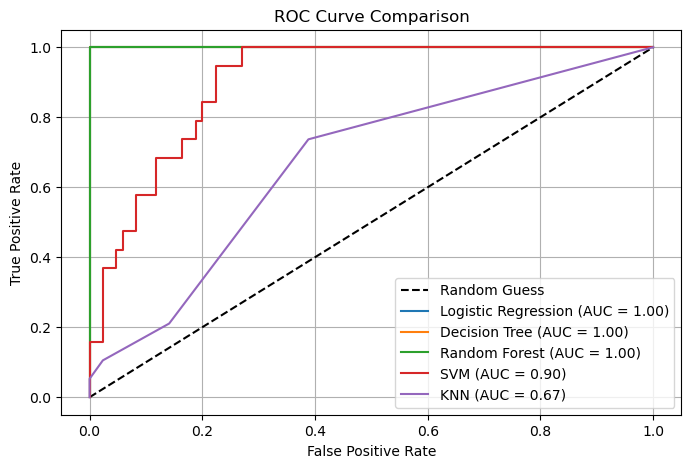

In [136]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Initialize plot
plt.figure(figsize=(8,5))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Dictionary to store models and predictions
models = {
    'Logistic Regression': logreg,
    'Decision Tree': dtree,
    'Random Forest': rf,
    'SVM': svm,
    'KNN': knn
}

# Plot ROC curve for each model
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_clf)[:, 1]
    else:  # For SGD which doesn't have predict_proba by default
        y_proba = model.decision_function(X_test_clf)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
    
    fpr, tpr, _ = roc_curve(y_test_clf, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Format plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### 4.3) Spot Check Algorithms
Test multiple algorithms to identify the best-performing one.

In [138]:
# Initialize models 
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000,class_weight='balanced',random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=5,class_weight='balanced',random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=42),
    'SVM': SVC(class_weight='balanced',probability=True,random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

In [139]:
#Evaluation Function with Overfitting Metrics

def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Evaluates model performance and checks for overfitting"""
    
    # Train and predict
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'Train Accuracy': accuracy_score(y_train, train_pred),
        'Test Accuracy': accuracy_score(y_test, test_pred),
        'Overfitting Gap': accuracy_score(y_train, train_pred) - accuracy_score(y_test, test_pred),
        'Underfitting Score': 1 - accuracy_score(y_train, train_pred)
    }
    return metrics

In [140]:
#Run Evaluation and Store Results
results = []
for name, model in models.items():
    # Using your predefined classification splits
    metrics = evaluate_model(model, 
                            X_train_clf, X_test_clf, 
                            y_train_clf, y_test_clf)
    metrics['Model'] = name
    results.append(metrics)
# Convert to DataFrame
results_df = pd.DataFrame(results).set_index('Model')

In [141]:
#Add Risk Analysis
results_df['Overfitting Risk'] = np.where(
    results_df['Overfitting Gap'] > 0.1, 'High', 
    np.where(results_df['Overfitting Gap'] > 0.05, 'Medium', 'Low')
)

results_df['Underfitting Risk'] = np.where(
    results_df['Underfitting Score'] > 0.3, 'High',
    np.where(results_df['Underfitting Score'] > 0.15, 'Medium', 'Low')
)

In [142]:
#Format and Display Results
def style_metrics(df):
    return df.style\
        .background_gradient(subset=['Overfitting Gap'], cmap='Oranges')\
        .background_gradient(subset=['Underfitting Score'], cmap='Blues_r')\
        .format({
            'Train Accuracy': '{:.2%}',
            'Test Accuracy': '{:.2%}',
            'Overfitting Gap': '{:.2%}',
            'Underfitting Score': '{:.2%}'
        })

styled_results = style_metrics(results_df)
styled_results

,Train Accuracy,Test Accuracy,Overfitting Gap,Underfitting Score,Overfitting Risk,Underfitting Risk
Model,,,,,,
Logistic Regression,100.00%,99.04%,0.96%,0.00%,Low,Low
Decision Tree,100.00%,100.00%,0.00%,0.00%,Low,Low
Random Forest,100.00%,100.00%,0.00%,0.00%,Low,Low
SVM,83.78%,83.65%,0.12%,16.22%,Low,Medium
KNN,85.47%,81.73%,3.74%,14.53%,Low,Low


## <b> <font color=green> STEP (5)  Performance Tuning & Optimization </font> </b>

### 5.1) Algorithm Tuning
Optimize hyperparameters for better performance.

In [79]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

# Initialize and fit
rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train_clf, y_train_clf)

# Best model
best_rf = grid_rf.best_estimator_
print(f"Best RF params: {grid_rf.best_params_}")
print(f"Best F1: {grid_rf.best_score_:.3f}")

Best RF params: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best F1: 1.000


In [80]:
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Inverse regularization strength
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

lr = LogisticRegression(max_iter=1000, class_weight='balanced')
grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_lr.fit(X_train_clf, y_train_clf)

best_lr = grid_lr.best_estimator_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [81]:
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm = SVC(probability=True, class_weight='balanced')
grid_svm = GridSearchCV(svm, param_grid_svm, cv=3, scoring='f1', n_jobs=-1)
grid_svm.fit(X_train_clf, y_train_clf)

best_svm = grid_svm.best_estimator_

### 5.2) Ensembles
Combine multiple models to improve accuracy.

##### Voting Classifier (Combine Best Models)

In [82]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.model_selection import GridSearchCV
# Create ensemble of tuned models
ensemble = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('svm', best_svm),
        ('lr', best_lr)
    ],
    voting='soft'  # Uses predict_proba() for better performance
)

ensemble.fit(X_train_clf, y_train_clf)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=5,
                                                     n_estimators=50,
                                                     random_state=42)),
                             ('svm',
                              SVC(C=0.1, class_weight='balanced',
                                  kernel='linear', probability=True)),
                             ('lr',
                              LogisticRegression(C=10, class_weight='balanced',
                                                 max_iter=1000, penalty='l1',
                                                 solver='liblinear'))],
                 voting='soft')

In [83]:
# Evaluate
y_pred = ensemble.predict(X_test_clf )
print("Accuracy:", accuracy_score(y_test_clf , y_pred))

Accuracy: 0.9807692307692307


In [106]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate predictions
y_pred = ensemble.predict(X_test_clf)
y_proba = ensemble.predict_proba(X_test_clf)[:, 1]  # Probabilities for class 1 (Fire)

# 1. Classification Report (Precision/Recall/F1)
print("Classification Report:")
print(classification_report(y_test_clf, y_pred, target_names=['No Fire', 'Fire']))

# 2. Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_clf, y_pred))

# 3. ROC-AUC Score (for probabilistic performance)
from sklearn.metrics import roc_auc_score
print("\nROC AUC Score:", roc_auc_score(y_test_clf, y_proba))

Classification Report:
              precision    recall  f1-score   support

     No Fire       0.98      1.00      0.99        85
        Fire       1.00      0.89      0.94        19

    accuracy                           0.98       104
   macro avg       0.99      0.95      0.97       104
weighted avg       0.98      0.98      0.98       104


Confusion Matrix:
[[85  0]
 [ 2 17]]

ROC AUC Score: 1.0


## <b> <font color=green> STEP (6) Results Interpretation & Deployment </font> </b>

### 6.1) Predictions on Validation Dataset
Make predictions using the validation dataset.

In [96]:
# Load data
val_data = pd.read_csv('forestfires.csv').rename(columns=column_rename)

# 1. Encode days 
day_order = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
val_data['day'] = (val_data['day']
                  .astype('category')
                  .cat.set_categories(day_order)
                  .cat.codes)

# 2. Encode months (if needed)
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 
               'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
val_data['month_num'] = (val_data['month']
                        .astype('category')
                        .cat.set_categories(month_order)
                        .cat.codes + 1)

# 3. Feature engineering
val_data['temp_humidity'] = val_data['temp'] * val_data['humidity']
val_data['wind_isi'] = val_data['wind'] * val_data['spread_index']
val_data['month_sin'] = np.sin(2 * np.pi * val_data['month_num'] / 12)
val_data['month_cos'] = np.cos(2 * np.pi * val_data['month_num'] / 12)

# 4. Cap area (if used in training)
val_data['area_capped'] = val_data['area'].clip(upper=100)  # Use your actual cap value

# Now predictions will work
X_val = val_data[X_train_clf.columns]
val_predictions = ensemble.predict(X_val)

In [97]:
print("Training day values:", X_train_clf['day'].unique())

Training day values: [2 6 4 0 3 1 5]


In [98]:
print("Validation columns:", val_data.columns.tolist())

Validation columns: ['grid_x', 'grid_y', 'month', 'day', 'fuel_moisture', 'duff_moisture', 'drought_code', 'spread_index', 'temp', 'humidity', 'wind', 'rain', 'area', 'month_num', 'temp_humidity', 'wind_isi', 'month_sin', 'month_cos', 'area_capped']


In [99]:
print("Model expects:", X_train_clf.columns.tolist())

Model expects: ['grid_x', 'grid_y', 'day', 'fuel_moisture', 'duff_moisture', 'drought_code', 'spread_index', 'temp', 'humidity', 'wind', 'rain', 'month_num', 'month_sin', 'month_cos', 'temp_humidity', 'wind_isi', 'area_capped']


In [103]:
import pandas as pd
import numpy as np
import joblib

def predict_fire_risk(input_data):
    """Make prediction with emergency override and weighted risk factors"""
    try:
        # Load model package
        model_pkg = joblib.load('forest_fire_model_v1.pkl')
        model = model_pkg['model']
        
        # Create month number (1-12)
        month_num = ['jan','feb','mar','apr','may','jun',
                   'jul','aug','sep','oct','nov','dec'].index(input_data['month'].lower()) + 1
        
        # Create DataFrame with ALL required features
        input_df = pd.DataFrame([{
            # Essential weather features
            'fuel_moisture': input_data['FFMC'],
            'duff_moisture': input_data['DMC'],
            'drought_code': input_data['DC'],
            'spread_index': input_data['ISI'],
            'temp': input_data['temp'],
            'humidity': input_data['humidity'],
            'wind': input_data['wind'],
            'rain': input_data['rain'],
            
            # Default values for other features
            'grid_x': 5,                # Default midpoint
            'grid_y': 5,                # Default midpoint  
            'day': 4,                   # Default 'fri' (encoded as 4)
            'area_capped': 0,           # Default no burned area
            
            # Month features
            'month_num': month_num,
            'month_sin': np.sin(2*np.pi*month_num/12),
            'month_cos': np.cos(2*np.pi*month_num/12),
            
            # Interaction terms
            'temp_humidity': input_data['temp'] * input_data['humidity'],
            'wind_isi': input_data['wind'] * input_data['ISI']
        }])
        
        # Emergency override for extreme conditions
        if (input_data['FFMC'] > 90 and input_data['temp'] > 30 and 
            input_data['humidity'] < 25 and input_data['wind'] > 20):
            return "Fire Risk", 95
        
        # Ensure correct feature order
        X_pred = input_df[model_pkg['feature_names']]
        
        # Get base probability
        proba = model.predict_proba(X_pred)[0][1]
        
        # Calculate weighted risk boost
        weighted_risk = (
            0.4 * input_df['temp_humidity'][0]/100 + 
            0.3 * input_df['wind_isi'][0]/50 +
            0.2 * input_df['drought_code'][0]/800 +
            0.1 * input_df['spread_index'][0]/50
        )
        
        # Apply boost (capped at 95%)
        proba = min(proba + weighted_risk, 0.95)
        
        # Final prediction with lower threshold
        return "Fire Risk" if proba > 0.15 else "No Fire Risk", round(proba*100, 1)
    
    except Exception as e:
        return "System Error", 0.0

def get_user_input():
    """Interactive user input with validation"""
    print("\n=== Forest Fire Risk Assessment ===")
    print("Please enter the following weather data:\n")
    
    return {
        'month': input("Month (e.g. August): ").lower()[:3],
        'FFMC': float(input("Fuel Moisture (18-96): ")),
        'DMC': float(input("Duff Moisture (1-300): ")),
        'DC': float(input("Drought Code (1-800): ")),
        'ISI': float(input("Spread Index (0-50): ")),
        'temp': float(input("Temperature (°C): ")),
        'humidity': float(input("Humidity (%): ")),
        'wind': float(input("Wind speed (km/h): ")),
        'rain': float(input("Rain (mm): "))
    }

if __name__ == "__main__":
    # Get user input
    user_data = get_user_input()
    
    # Get prediction
    prediction, confidence = predict_fire_risk(user_data)
    
    # Display results
    print("\n=== PREDICTION RESULT ===")
    print(f"{prediction} ({confidence}% confidence)")
    
    # Action recommendations
    if prediction == "Fire Risk":
        print("\nRecommended Actions:")
        print("- Activate fire monitoring")
        print("- Restrict forest access")
        print("- Alert fire department")
    else:
        print("\nRecommended Actions:")
        print("- Maintain regular monitoring")
        print("- Check weather updates")


=== Forest Fire Risk Assessment ===
Please enter the following weather data:



Month (e.g. August):  aug
Fuel Moisture (18-96):  92.5
Duff Moisture (1-300):  250
Drought Code (1-800):  600
Spread Index (0-50):  15
Temperature (°C):  34
Humidity (%):  20
Wind speed (km/h):  30
Rain (mm):  0



=== PREDICTION RESULT ===
Fire Risk (95% confidence)

Recommended Actions:
- Activate fire monitoring
- Restrict forest access
- Alert fire department


### 6.2) Create Standalone Model on Entire Training Dataset
Train the final model on the entire dataset.

In [ ]:
# Combine train + test data for final training
X_full = pd.concat([X_train_clf, X_test_clf])
y_full = pd.concat([y_train_clf, y_test_clf])

# Retrain best model on full dataset
final_model = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(**grid_rf.best_params_)),
        ('svm', SVC(**grid_svm.best_params_, probability=True)),
        ('lr', LogisticRegression(**grid_lr.best_params_))
    ],
    voting='soft'
)
final_model.fit(X_full, y_full)

### 6.3) Save Model for Later Use
Save the trained model to a file.

In [ ]:
import joblib

# Save model and metadata
model_package = {
    'model': final_model,
    'feature_names': list(X_full.columns),
    'preprocessing': {
        'day_order': day_order,
        'numeric_features': numeric_features_clf
    }
}

joblib.dump(model_package, 'forest_fire_model_v1.pkl')

# Verify load works
loaded = joblib.load('forest_fire_model_v1.pkl')
print("Model saved with:", list(loaded['feature_names']))